# Setup

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# append project root to sys.path to import modules
# alternatively package the application and install with pip install --editable
from pathlib import Path
import sys
project_dir = str(Path.cwd().parent)

for d in [project_dir, '/Users/Tom/Dropbox/workspace/faillissementsdata_db']:
    if d not in sys.path:
        print('adding %s' % d)
        sys.path.append(d)
print(sys.path)

adding /Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis
adding /Users/Tom/Dropbox/workspace/faillissementsdata_db
['', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python36.zip', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python3.6', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python3.6/lib-dynload', '/Users/Tom/.pyenv/versions/3.6.3/lib/python3.6', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python3.6/site-packages', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python3.6/site-packages/IPython/extensions', '/Users/Tom/.ipython', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis', '/Users/Tom/Dropbox/workspace/faillissementsdata_db']


In [6]:
#import pdb; pdb.set_trace()
%matplotlib inline  
# connection to the database
import os
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# set username/password here:
db = {'username': os.environ['DB_QIR_USERNAME'],
      'password': os.environ['DB_QIR_PASSWORD'],
      'host': 'www.quantleap.nl',  
      'catalog': 'qir'}

con = 'postgresql://{username}:{password}@{host}/{catalog}'.format(**db)
engine = create_engine(con, echo=True)

# create a configured "Session" class and create session
Session = sessionmaker(bind=engine)
session = Session()

# psycopg connection
conn = psycopg2.connect(con)

print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


In [7]:
import datetime
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()  # apply the default default seaborn theme, scaling, and color palette.
from app.model.process import *


# Process Mining
Events on the timeline 

## Determination of the insolvency start date 
### From Publication
Certain publication codes and descriptions indicate a start date of the insolvency. 

Examples:
- '1300': r'uitspraak faillissement op ...'
- '1301': r'uitspraak faillissement door tussentijdse beëindiging schuldsanering op ...'
- '1302': r'uitspraak faillissement tijdens schuldsanering op ...'
- '1303': r'uitspraak faillissement door ontbinding akkoord in schuldsanering op ...'

all start codes = ['1100', '1200', '1300', '1301', '1302', '1303', '1304', '1305', '1306', '3313']

### Alternative sources
- earliest start date on administrator_receiver
- earliest start date on addresses_insolvent
- earliest start date on addresses_business_name

### Completeness insolvency start date

In [8]:
insolvency_start_date_completeness(only_active=True, cutoff_date=date(2005, 1, 1))

{'with_start_date': 16116, 'without_start_date': 0, 'completeness': 1.0}


# Bankruptcies over time

## New bankruptcies

In [9]:
from app.model.process import insolvency_start_date_count
from datetime import date

s = insolvency_start_date_count().resample('M').sum()

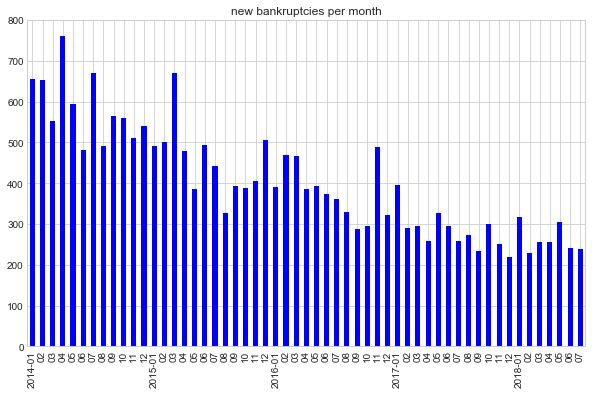

In [10]:
fig = plot_insolvency_start_date_count(s)

In [11]:
import mpld3
mpld3.enable_notebook()
mpld3.display(fig)

## Active bankruptcies